Get the difference between nucleus and TFS set of words. See if the words in this set are reasonable. They should be reasonable for when TFS is looser and should not be when TFS is tighter. Out of this set of words, take the highest, lowest prob ones and the middle one? Need at least 3 word gap between them. 
Rank each one in how reasonable it is. Control baseline is how reasonable words at different points in the body are. The first word, half way and at the closer of the tails. Can also get words outside of the last tail, just outside, halfway to the end, and at the very end. 
There are 9 different words in total. Should i rank all of them, scramble up a subset? Or have a ranking for each of the subsets differently? Probably scramble them all up. And then present 3 of them??
Can then see overall how replaceable different parts of the distributions is, and for TFS and nucleus specifically. Have a control with the bad words. And should be able to hopefully show that the difference in replaceability between the TFS and nucleus words is small when TFS is looser and large when TFS is tighter. Can see how specific this is also. Eg could just look at the last TFS and nucleus words, see the diff in replaceability, or maybe need to look at the averages. Look most at this unique subset and these three points should hopefully categorize it. Want them because i dont know how good the signal is going to be. For the closest words for example. 
Can also get overall data on how replaceability corresponds to model probability. 


In [2]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd    
import torch

In [3]:
from decodeLogits import *

In [3]:
#updated
vals_dict = {'tfs':[0.25, 0.75, 0.9, 0.95, 0.99],
'n': [0.5, 0.63, 0.69, 0.81, 0.75, 0.9], 'k':[1,40,200]  }


''' {'tfs':[0.25, 0.75, 0.9, 0.95, 0.99], 'flat':[0.01, 0.02, 0.05],
'n': [0.1, 0.25, 0.5, 0.63, 0.69, 0.75, 0.81, 0.9], 'k':[1,10,40,200]  }'''

" {'tfs':[0.25, 0.75, 0.9, 0.95, 0.99], 'flat':[0.01, 0.02, 0.05],\n'n': [0.1, 0.25, 0.5, 0.63, 0.69, 0.75, 0.81, 0.9], 'k':[1,10,40,200]  }"

# Doing analysis for the same logit going to use the ground truth as it is a Schelling point

In [4]:
from importlib import reload
import utils

reload(utils)
from utils import *

In [5]:
batch_size=25
num_batches=4
prompt_length=100
generated_length=150
tot_len = prompt_length+generated_length

import encoder
model_name='774M' #345M
models_dir='../gpt-2/models'
enc = encoder.get_encoder(model_name, models_dir)

prompts=pd.read_csv('test_dataframe_500primer.csv')

In [6]:
gpt_out_path = 'gpt-2_output/'
additional_path = '-model_774M-seed_27'#'' 
#all_perps = pickle.load( gzip.open(gpt_out_path+'all_perplexities_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv'+additional_path+'.pickle.gz', 'rb'))
all_logits = pickle.load( gzip.open(gpt_out_path+'all_logits_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv'+additional_path+'.pickle.gz', 'rb')) # needed to get the probabilities
text = pickle.load( gzip.open(gpt_out_path+'all_text_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv'+additional_path+'.pickle.gz', 'rb'))

In [7]:
tot_num = 0
mapping_to_batch = dict()
for i in range(num_batches):
    num_in_batch = all_logits[i].shape[0]
    for el, b_ind in zip(range(tot_num, tot_num+num_in_batch), range(0, num_in_batch)):
        mapping_to_batch[el] = (i, b_ind) # actual batch and then the ind in that batch
    print( num_in_batch)
    tot_num+= num_in_batch
tot_num

23
23
24
22


92

In [8]:
all_logits[0].shape

(23, 150, 50257)

# Want to generate things that are at the different probability levels

# Looking at max deviation and getting these points within the tails of each

## Want to also focus on the maximum deviation portions at some point. 

In [9]:
# random prompts and locations within the 150 generation locations

num_prompts_and_timepoints_wanted = 100 # cant be larger than 100 right now!!!
assert num_prompts_and_timepoints_wanted <=100
leading_prompt = 15

want_min_max = False

if want_min_max==True:
    minmax = pd.read_csv('Min_Max_Disagreement_Coords_TFS90.csv')
    #shuffle it and take the number that is wanted. 
    minmax = minmax.sample(frac= num_prompts_and_timepoints_wanted/minmax.shape[0])
    display(minmax.head())
    
else:
    rand_prompts = np.random.randint(0,tot_num, num_prompts_and_timepoints_wanted)
    # leadingprompt until 150. as the logits are 150 not 250. 
    # -1 because of the end token prediction
    rand_times = np.random.randint(0,generated_length-1, num_prompts_and_timepoints_wanted)

,MinorMax,batch_ind,ind_in_batch,time_point
95,Max,3,3,86
31,Min,1,10,117
99,Max,1,10,125
56,Max,1,7,55
6,Min,0,10,39


In [11]:
from importlib import reload
import utils

reload(utils)
from utils import *

In [4]:
len(all_logits[0][0, :, 0])

NameError: name 'all_logits' is not defined

getting random locations
for the differnet gen strategies. find the tail locations. take the tokens at each position. 
move onto the next random location. 

In [6]:
np.arange(0,1.1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [21]:
# applying all analyses to the logits. 
prompt_length = 100
to_df = []
prob_slices_wanted = np.arange(0,1.1,0.1)

# randomly select generations and positions in those generations. from the original prompts. 
for r_ind in range(0, num_prompts_and_timepoints_wanted):
    
    if want_min_max ==True:
        prompt = 999
        batch_ind, ind_in_batch = minmax.iloc[r_ind, 1], minmax.iloc[r_ind, 2]
        time_point = minmax.iloc[r_ind,3]
        if time_point>=149:
            continue # because of the stop token being predicted. 
        text_timepoint = time_point+prompt_length+1 # +1 because the perplexities keeps the end prediction token. 
    else:
        prompt = rand_prompts[r_ind]
        time_point = rand_times[r_ind]
        text_timepoint = time_point+prompt_length+1 # +1 because the perplexities keeps the end prediction token. 
        batch_ind, ind_in_batch = mapping_to_batch[prompt]
    
    diff_tail_positions = dict()
    largest_tail_id = 0
    method_of_largest_tail_id = None
    
    sps = softmax(-np.sort(-all_logits[batch_ind][ind_in_batch, time_point, :]))
    indices = np.argsort(-all_logits[batch_ind][ind_in_batch, time_point, :])
    ground_token = text[batch_ind][ind_in_batch][text_timepoint]
    # what the ground token is
    ground_word = decoder_text([ground_token])
    
    #get the 15 words in front. 
    lead_prompt_words = decoder_text(text[batch_ind][ind_in_batch][text_timepoint-leading_prompt:text_timepoint])
    df_row = [prompt, time_point, batch_ind, ind_in_batch, lead_prompt_words, ground_word] # taking it from the last one. 
    
    
    #remove any non word tokens from whole list. (could be done more efficiently)
    unique_tokens, relative_pos = remove_non_words(indices)
    # select the right positions and words: 
    #NEED TO IGNORE ANY OF THE SLICES THAT ARE TOO LARGE.  TAKE THE HIGHEST PROB WORD AND THEN DO THE SLICES.
    words_and_positions_wanted = get_specific_positions_from_probs(unique_tokens, prob_slices_wanted, relative_pos)
                
    '''for key,all_params in vals_dict.items():
        for par in all_params:
            method = key+'_'+str(par)
            if method in methods_wanted:
            
                if key == 'tfs':
                    first = sps[1:] - sps[:-1]
                    second = first[1:] - first[:-1]
                    tail_id = new_tfs(second, par)
                elif key=='flat':
                    tail_id = flat(sps, par)
                elif key=='n':
                    tail_id = nucleus_calc(sps, par)
                elif key=='k':
                    tail_id = par
                else:
                    print('key not recognized')
                    break
                    
                if tail_id > largest_tail_id:
                    largest_tail_id=tail_id
                    method_of_largest_tail_id=method
            
                diff_tail_positions[method] = tail_id#, ids_above_tail)

    if len(diff_tail_positions.keys()) >2: 
        print('CURRENTLY CANT LOOK AT MORE THAN 2 THINGS!')
        break
        
    # indices is still sorted. and can be used 
    smaller_method = list(diff_tail_positions.keys())
    smaller_method.remove(method_of_largest_tail_id)
    smaller_method = smaller_method[0]
    smaller_tail_id = diff_tail_positions[smaller_method]
    
    #now I deal with this later where I can rerun the nucleus part of it. 
    #if largest_tail_id - smaller_tail_id < 3:
    #    #print('not enough space between the tail locations')
    #    continue'''
        
    diff_tail_positions['InTail'] = 50527
    for method in methods_wanted: # want to do them in the same order.
        # add the tail for each method: 
        df_row += [diff_tail_positions[method]]
        if method == method_of_largest_tail_id: # the cut between the tighter and looser
            unique_tokens = indices[smaller_tail_id:largest_tail_id]
            starting_pos = smaller_tail_id
        elif method == 'InTail': #the tail itself
            unique_tokens = indices[largest_tail_id:]
            starting_pos = largest_tail_id
        else: # the closest one
            unique_tokens = indices[:smaller_tail_id]
            starting_pos = 0
            
        
        
        while method_of_largest_tail_id == tfs_label and words_and_positions_wanted[0] == [None,None,None]: # need to rerun with a looser nucleus threshold. 
            # get a tighter nucleus sample
            nuc_org = nuc_org-0.03
            tail_id = nucleus_calc(sps, nuc_org)
            
            if tail_id == 1: # cant get any tighter. 
                break
            
            unique_tokens = indices[:tail_id]
            starting_pos = 0
            
            unique_tokens, relative_pos = remove_non_words(unique_tokens)
            # select the right positions
            words_and_positions_wanted = get_specific_positions(unique_tokens, starting_pos, relative_pos)

        specific_probs = []
        for abs_pos in words_and_positions_wanted[1]:
            specific_probs.append(sps[abs_pos])
        
        df_row += [words_and_positions_wanted[0], words_and_positions_wanted[1], specific_probs ]
        
    to_df.append(df_row)

In [33]:
results = pd.DataFrame(to_df, columns = ['prompt_ind', 'time_point', 
                               'batch_ind', 'ind_in_batch', 'leading_words',
                               'ground_word', 'looser_method', 'tail_pos_'+methods_wanted[0], 
        'specific_words_'+methods_wanted[0], 'positions_'+methods_wanted[0],'probs'+methods_wanted[0],
                                         'tail_pos_'+methods_wanted[1],
                    'specific_words_'+methods_wanted[1], 'positions_'+methods_wanted[1],
                    'probs'+methods_wanted[1],'tail_pos_'+methods_wanted[2],
                    'specific_words_'+methods_wanted[2], 'positions_'+methods_wanted[2], 'probs'+methods_wanted[2]])

In [59]:
assert results.drop_duplicates('leading_words').shape == results.shape

In [60]:
# need to remove nones: 
none_mask = []
for ind in range(results.shape[0]):
    if results.loc[ind, 'specific_words_'+tfs_label]==[None, None, None] or results.loc[ind, 'specific_words_'+nuc_label]==[None, None, None]:
        none_mask.append(False)
    else:
        none_mask.append(True)
        
print('number that are not none', sum(none_mask))

number that are not none 58


In [36]:
results = results[none_mask]

In [37]:
results.shape

(58, 19)

In [38]:
results.head()

,prompt_ind,time_point,batch_ind,ind_in_batch,leading_words,ground_word,looser_method,tail_pos_tfs_0.9,specific_words_tfs_0.9,positions_tfs_0.9,probstfs_0.9,tail_pos_n_0.63,specific_words_n_0.63,positions_n_0.63,probsn_0.63,tail_pos_InTail,specific_words_InTail,positions_InTail,probsInTail
1,999,117,1,10,aged weapons. Everyone else was given or assi...,infantry,n_0.63,13,"[only, last, most]","[0, 6, 12]","[0.06087858, 0.008750073, 0.0055404124]",550,"[humans, captain, workforce]","[13, 275, 549]","[0.0052030683, 0.00049465947, 0.00025142057]",50527,"[name, nutrients, interstitial]","[550, 21428, 50224]","[0.0002514129, 8.5582576e-07, 1.9516675e-11]"
3,999,55,1,7,"never understood words too well, but I guess ...",;,tfs_0.9,6,"[and, for, because]","[0, 2, 3]","[0.33381513, 0.09870116, 0.07159144]",4,"[and, for, because]","[0, 2, 3]","[0.33381513, 0.09870116, 0.07159144]",50527,"[as, drains, cumbers]","[6, 21375, 50249]","[0.014609966, 1.7478184e-08, 7.535083e-14]"
4,999,39,0,10,no longer individuals. Mothers are no longer ...,occasional,n_0.63,7,"[jokes, pun, a]","[0, 3, 6]","[0.084562816, 0.009146591, 0.007705728]",579,"[to, image, inventions]","[7, 297, 578]","[0.007355045, 0.00052459346, 0.00028983405]",50527,"[impressions, Fitzgerald, conservancy]","[580, 20968, 50238]","[0.00028833427, 3.9972744e-07, 6.7375017e-13]"
5,999,14,1,17,"\n \n A child's broken plaything, risen with e...",c,n_0.63,8,"[and, its, but]","[0, 4, 7]","[0.0692719, 0.010805639, 0.00824078]",374,"[with, leaving, turns]","[8, 202, 373]","[0.0060455734, 0.0009405914, 0.0005247816]",50527,"[sought, mainland, Interstitial]","[374, 21177, 50216]","[0.00052268384, 2.634107e-07, 1.730388e-11]"
8,999,47,2,1,would realize truly how powerful Anonymous wa...,friends,n_0.63,5,"[newfound, mask, father]","[0, 2, 4]","[0.071420684, 0.020989213, 0.01060408]",425,"[success, creative, trusted]","[5, 212, 424]","[0.010030248, 0.0006455564, 0.00034931596]",50527,"[huge, fall, Els]","[425, 21131, 50249]","[0.00034922536, 5.2094526e-07, 3.5534642e-12]"


In [39]:
(results['looser_method'] == nuc_label).sum() # only 12 of these have TFS as the looser method. 
# using iterative nucleus i got this up to 15
# need to try other tighter nucleus values for these ones. 

43

In [46]:
results.reset_index(inplace=True)
results.drop('index', axis=1, inplace=True)

In [47]:
results.to_csv('backup_of_different_tail_slices.csv')

In [41]:
samp_methods = set(results['looser_method'].unique().tolist())
# want to get the specific entries from each: 
results.apply()

TypeError: apply() missing 1 required positional argument: 'func'

In [48]:
file_name_base = 'tail_replaceable_comparisons'

In [49]:
answer_orders = []
with open(file_name_base + '_blind_output.txt', 'w') as file: 
    file.write('For each of the following assignments, rank on a scale of 1-5 how replaceable each word is, given the provided context. \n')
    file.write('Some words are stems, if the word could be completed then you can still rank it highly. And be generous with acronyms that could be plausible. ')
    file.write('===================================================== \n \n')
    for ind in range(results.shape[0]):
        file.write('Prompt '+str(ind)+'. \n')
        file.write('The '+str(leading_prompt)+' words in front: \n \n')
        file.write(results.loc[ind, 'leading_words']+' _______')
        file.write('\n')
        
        words = [results.loc[ind, 'ground_word']]
        order = ['ground_word']
        for m in methods_wanted: 
            col = 'specific_words_'+m
            words += results.loc[ind, col]
            for i in range(1,4):
                order.append(m+"-"+str(i))
                
        words =np.asarray(words)
        order = np.asarray(order)
        
        #print(words, order)
        shuffler = np.random.choice(range(len(words)), size =len(words), replace=False )
        
        words = words[shuffler]
        order = order[shuffler]
        answer_orders.append(list(order))
        #print('after', words, order)
        
        for i in range(len(words)):
            file.write(str(i+1)+'. '+words[i]+' ')
                
        file.write('\n \n')
        file.write('=====================================================')
        file.write('\n \n')
        
with open(file_name_base + '_answers.txt', 'w') as file: 
    for ind, order in enumerate(answer_orders):
        file.write('Prompt '+str(ind)+' : \n')
        for el_ind, el in enumerate(order): 
            file.write(str(el_ind+1) + '. '+el +' ')
        file.write('\n')
        file.write('=====================================================')
        file.write('\n')

pickle.dump(answer_orders,open(file_name_base + '_answers_list.pickle','wb'))

In [234]:
res = [[3, 5, 4, 5, 5, 4, 1, 3, 2, 1],
       [5, 5, 5, 1, 5, 1, 4, 5, 4, 5], 
       [4, 5, 4, 2, 2, 4, 2, 1,1, 5], 
       [4, 4, 5, 4, 4, 2, 5, 4, 5, 2], 
       [5, 5, 5, 1, 3, 4, 5, 5, 5, 4], 
       [4, 3, 5,5,4,5, 5, 4, 1,1], 
       [5, 5, 4, 1, 4, 5,1,4,4,2], 
       [5,4,2,1,5,4,1,1,5,1], 
       [3,4,5,5,4,1,3,5,4,5]]


In [235]:
for r in res: 
    print(len(r))

10
10
10
10
10
10
10
10
10


In [236]:
methods_wanted[-2]

'n_0.69'

In [237]:
tfs_tighter = dict()
nuc_tighter = dict()

for ind, (r, a) in enumerate(zip(res, answer_orders)):
    lose_method = results.loc[ind, 'looser_method']
    for r_el, a_el in zip(r,a):
        if lose_method == tfs_label:
            try:
                nuc_tighter[a_el].append(r_el)
            except:
                nuc_tighter[a_el] = [r_el]
        else: 
            try:
                tfs_tighter[a_el].append(r_el)
            except:
                tfs_tighter[a_el] = [r_el]

In [257]:
tfs_tighter = pd.DataFrame(tfs_tighter)
nuc_tighter = pd.DataFrame(nuc_tighter)

In [275]:
from importlib import reload
import utils

reload(utils)
from utils import *

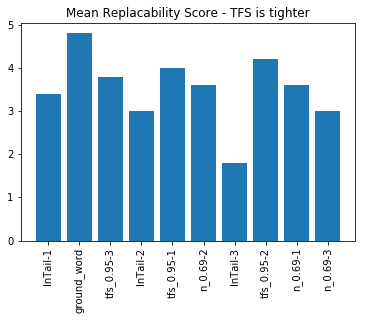

In [276]:
bar_plot_columns(tfs_tighter, 'TFS is tighter')

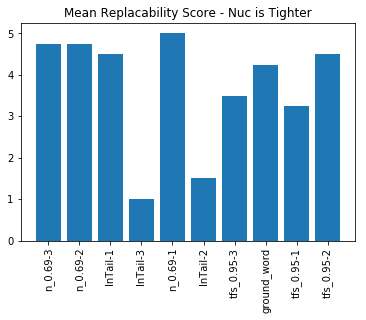

In [279]:
bar_plot_columns(nuc_tighter, 'Nuc is Tighter')

Want when Nuc is tighter for the difference between Nuc and TFS to be smaller than it is when TFS is tighter. 

In [280]:
abs_diff_of_different_locations(tfs_tighter, tfs_label, n_label)

position: 1 = 0.3999999999999999
position: 2 = 0.6000000000000001
position: 3 = 0.7999999999999998


In [281]:
abs_diff_of_different_locations(nuc_tighter,tfs_label, n_label)

position: 1 = 1.75
position: 2 = 0.25
position: 3 = 1.25
